# Importing the Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = r"D:\Projects\Mini_Projects\Mental_Health_Survey\Research_Data\preprocessed_data.csv"

In [3]:
data = pd.read_csv(file_path)

In [4]:
data.head()

,Unnamed: 0,Gender,Age,City,Profession,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,0,49,15,4,2,1,0,9,0,1,2,0,0
1,1,1,26,26,36,3,2,2,12,1,7,3,0,1
2,2,1,33,28,28,0,0,0,3,1,3,1,0,1
3,3,1,22,17,36,1,2,1,6,1,10,1,1,1
4,4,0,30,12,3,1,0,2,6,1,9,4,1,0


In [5]:
data.shape

(135769, 14)

In [6]:
data['Depression'].value_counts()

Depression
0    111197
1     24572
Name: count, dtype: int64

# Model Building

In [7]:
# Target Variable


val = data.drop('Depression', axis = 1)
tar = data['Depression']

In [8]:
# Imbalance Handling 

sampler = RandomOverSampler(random_state = 65)

In [9]:
os_val, os_tar = sampler.fit_resample(val, tar)     # Over Sampling


In [10]:
# feature selection 

# Hyperparameter tuning

fs = RandomForestClassifier(n_estimators= 200, max_depth= 3, random_state= 65) # Applying the Random Forest Classifier with 200 trees and max depth of 3

fs.fit(os_val, os_tar)

RandomForestClassifier(max_depth=3, n_estimators=200, random_state=65)

In [11]:
# Feature Importance

# Feature Importance is a technique used to identify the most significant features in a dataset that contribute to the prediction of the target variable. It helps in understanding which features have the most impact on the model's performance.

s_col = pd.DataFrame({
    "col": os_val.columns,
    "score": fs.feature_importances_
}).sort_values('score', ascending = False). head(10)['col'].to_list()

In [12]:
s_col

['Age',
 'Job Satisfaction',
 'Have you ever had suicidal thoughts ?',
 'Profession',
 'Financial Stress',
 'Work/Study Hours',
 'Dietary Habits',
 'Degree',
 'Sleep Duration',
 'City']

In [13]:
# Train Test Split with Stratified Sampling

# Stratified sampling is a technique used to ensure that each class in the target variable is represented proportionally in both the training and testing datasets. This is particularly important when dealing with imbalanced datasets, as it helps to maintain the distribution of classes in both sets.

tr_data, ts_data, tr_lab, ts_lab = train_test_split(os_val, os_tar, test_size = 0.2, random_state = 65)

In [14]:
tr_data.shape, ts_data.shape, tr_lab.shape, ts_lab.shape

((177915, 13), (44479, 13), (177915,), (44479,))

In [15]:
# Deep Laerning Model with Keras

# Keras is a high-level neural networks API that allows for easy and fast prototyping of deep learning models. It provides a user-friendly interface to build and train neural networks, making it accessible for both beginners and experienced practitioners.

# A deep learning model is a type of artificial neural network that consists of multiple layers of interconnected nodes (neurons). These models are capable of learning complex patterns and representations from data, making them suitable for various tasks such as image recognition, natural language processing, and more.

model = Sequential([
    Dense(100, activation='relu', input_shape=(tr_data.shape[1],)),
    BatchNormalization(), 
    Dropout(0.3),  

    Dense(65, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(35, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(15, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='relu'),

    Dense(1, activation='sigmoid')
])

In [16]:
# Optimizer and Compilation


optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
# The optimizer is a crucial component in training deep learning models. It is responsible for updating the model's weights based on the computed gradients during backpropagation. The choice of optimizer can significantly impact the convergence speed and overall performance of the model.

# The compilation step involves specifying the optimizer, loss function, and evaluation metrics for the model. The optimizer is an algorithm used to update the weights of the model during training. It helps in minimizing the loss function and improving the model's performance.

# The optimizer is a key component in training deep learning models. It is responsible for updating the model's weights based on the computed gradients during backpropagation. The choice of optimizer can significantly impact the convergence speed and overall performance of the model.

# The optimizer is an algorithm used to update the weights of the model during training. It helps in minimizing the loss

# The loss function measures how well the model's predictions align with the actual target values. In this case, binary crossentropy is used as the loss function, which is suitable for binary classification tasks.

# The evaluation metrics are used to assess the model's performance during training and validation. In this case, accuracy is used as the evaluation metric, which measures the proportion of correct predictions made by the model.
# function and improving the model's performance.

# The compilation step involves specifying the optimizer, loss function, and evaluation metrics for the model.

In [18]:
# Model Training

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [19]:
# Early stopping is a technique used to prevent overfitting during the training of deep learning models. It monitors the model's performance on a validation set and stops training when the performance starts to degrade, thus saving time and resources
history = model.fit(tr_data, tr_lab, validation_data=(ts_data, ts_lab),
                    epochs=50, batch_size=64, callbacks=[early_stopping], verbose=1) # fit the model on the training data


Epoch 1/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.5002 - loss: 0.7045 - val_accuracy: 0.5057 - val_loss: 0.6926
Epoch 2/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.5005 - loss: 0.6933 - val_accuracy: 0.5031 - val_loss: 0.6928
Epoch 3/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.5013 - loss: 0.6931 - val_accuracy: 0.5031 - val_loss: 0.6927
Epoch 4/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.5053 - loss: 0.6926 - val_accuracy: 0.5014 - val_loss: 0.6935
Epoch 5/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.5059 - loss: 0.6919 - val_accuracy: 0.5026 - val_loss: 0.6935
Epoch 6/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.5070 - loss: 0.6921 - val_accuracy: 0.5208 - val_loss: 0.6925
Epoch 7/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.6739 - loss: 0.5734 - val_accuracy: 0.8860 - val_loss: 0.3262
Epoch 8/50
2780/2780 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7548 - loss

In [20]:
# The fit method is used to train the model on the training data. It takes the training data, validation data, number of epochs, batch size, and callbacks as input parameters. The verbose parameter controls the level of output during training.

In [21]:
ts_pred = (model.predict(ts_data) > 0.5).astype(int) # Predicting the test data 

1390/1390 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [22]:
ts_probs = model.predict(ts_data).flatten() # Predicting the probabilities of the test data and flattening the output to a 1D array


1390/1390 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [23]:
# The predict method is used to make predictions on the test data. It returns the predicted class labels for the input data. The probabilities are also computed, which represent the model's confidence in its predictions.
# The flatten method is used to convert the output to a 1D array, making it easier to work with.

In [24]:
fpr, tpr, _ = roc_curve(ts_lab, ts_probs) # Computing the ROC curve


# The ROC curve is a graphical representation of the model's performance at various threshold settings. It plots the true positive rate (sensitivity) against the false positive rate (1-specificity). The AUC score quantifies the overall performance of the model, with a score of 1 indicating perfect performance and a score of 0.5 indicating random guessing.

In [25]:
auc_score = roc_auc_score(ts_lab, ts_probs) # Computing the AUC score

In [26]:
# Evaluating the Model

accuracy = accuracy_score(ts_lab, ts_pred)
precision = precision_score(ts_lab, ts_pred)
recall = recall_score(ts_lab, ts_pred)
f1 = f1_score(ts_lab, ts_pred)

In [27]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print("\n =============== Classification Report: ===============")
print(f"\n {classification_report(ts_lab, ts_pred)}")

Test Accuracy: 0.8968
Test Precision: 0.8691
Test Recall: 0.9349
Test F1-Score: 0.9008

 =============== Classification Report: ===============

               precision    recall  f1-score   support

           0       0.93      0.86      0.89     22178
           1       0.87      0.93      0.90     22301

    accuracy                           0.90     44479
   macro avg       0.90      0.90      0.90     44479
weighted avg       0.90      0.90      0.90     44479



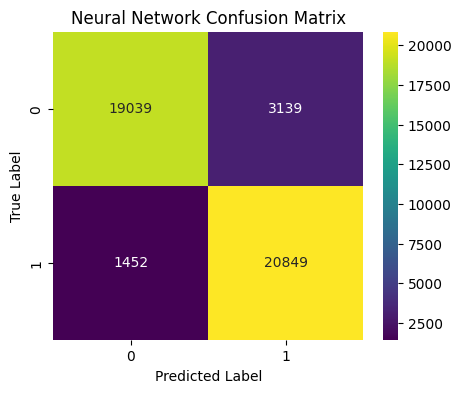

In [28]:
# plotting the NN Confusion Matrix

plt.figure(figsize=(5, 4))
cm = confusion_matrix(ts_lab, ts_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Neural Network Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

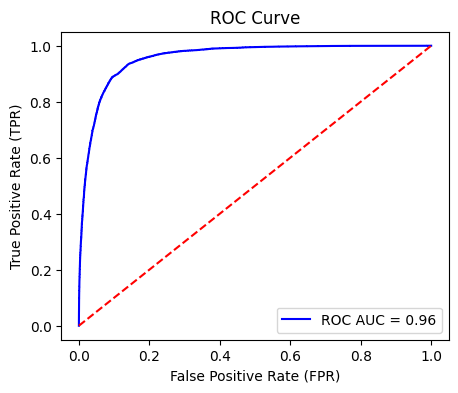

In [29]:
# Plotting the ROC Curve

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [32]:
! pip show tensorflow

In [30]:
# Model saving is an essential step in the machine learning workflow. It allows you to save the trained model to disk, making it possible to load and use the model later without having to retrain it. Keras provides a simple way to save and load models using the save and load_model functions.
# The save function saves the entire model, including the architecture, weights, and training configuration, to a single file. This makes it easy to share and deploy the model in different environments.
# Saving the trained model is an important step in the machine learning workflow. It allows you to reuse the model for future predictions without having to retrain it from scratch. Keras provides a simple way to save and load models using the save and load_model functions.

In [31]:
# Model Saving with Keras


model.save('D:\\Projects\\Mini_Projects\\Mental_Health_Survey\\Model\\neural_network.keras')
print('Model Successfully Saved to \Models')

Model Successfully Saved to \Models
